# Maximum Likelihood and Applications in Astronomy, Part II

M. Juric & Z. Ivezic 2019

## Least Squares as Maximum Likelihood

![alt text](figures/multiple-linear-regression-11-638.jpg)

Credit: https://www.slideshare.net/jtneill/multiple-linear-regression

Statement of the problem:

* We've collected a set of $N$ data points $x_i, y_i$.
* Our model for their behavior is $y(x) = a x + b $.
* We wish to find the "best" $a$ and $b$ that describe the measured data

Solution:
* What does "good" (or "best") mean? Intuitively, a good fit is one where the line "passes through the points" (or comes as close as possible to them). In other words, where the *residuals*, $r_i = y_i - y(x_i)$, are small.
* Hmm, but minimizing the residual for one point may be in tension with the residuals of other points. How do we find the right balance?
* Least squares wisdom: the path to balance lies in minimizing the ***sum of the squares of the residuals***:

$$ {min}_{a, b} \, Q(a, b) = {min}_{a, b} \sum_{i=1}^N (y_i - y(x_i))^2 $$

## Finding the minimum

$$ \frac{\partial Q}{\partial a} = 0 \;\;{\rm and}\;\; \frac{\partial Q}{\partial b} = 0; $$

$$ {\rm solve\,for\,}a{\rm \,and\,}b. $$

Let's start solving:

$$
\frac{\partial Q}{\partial a} = \sum_{i=1}^N \frac{\partial}{\partial a}\left(y_i - \left(a x_i + b\right)\right)^2 = 
\sum_{i=1}^N (y_i - (a x_i + b)) (- x_i) = 0
$$

$$
\frac{\partial Q}{\partial b} = \sum_{i=1}^N \frac{\partial}{\partial b}(y_i - (a x_i + b))^2 = 
\sum_{i=1}^N (y_i - (a x_i + b)) (- 1) = 0
$$

This gives us two coupled linear equations for $a, b$. After some straightforward but tedious math, we recover the well known result:

$$ a = \frac{\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^N (x_i - \bar{x})^2} $$

and

$$ b = \bar{y} - a \bar{x} $$

## Problems

Least squares method, as introduced above, has some problems:
* Why least *squares*? Why not ${residuals}^4$? Or least absolute value? It's not clear that the choice of squares is well motivated.
* What happens when we have error bars known for every datum $y_i$? We know the prescriptive answer is to divide the residual by the error, but where does that come from?
* And what would we do if we had error bars specified for both $x$ *and* $y$?

## Fitting a Line using a Maximum Likelihood Estimator

We can motivate the least squares method from ML perspective.

Assume the scatter in our measurements (the residuals) is generated by drawing them from a Gaussian. I.e.:

$$ y_i = y(x_i) + r_i = a x_i + b + r_i $$

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces. Note this is the same as saying that $ y_i$ is drawn from $N\left(y(x), \sigma\right)$.

Let us compute the likelihood. First, we ask ourselves what is the probability $p(y_i|x_i, a, b, \sigma)$ that a particular value $y_i$ would be measured at $x = x_i$? It is just the normal distribution:

$$ p(y_i|x_i, a, b, \sigma) = N\left(y_i \mid y(x), \sigma\right) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - y(x_i))^2}{2 \sigma^2} \right) $$.

Assuming the measurements are independent, the likelihood is then the product of individual probabilities for every $y_i$:

$$ L(a, b) = \prod_{i=1}^N \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - y(x_i))^2}{2 \sigma^2} \right) $$.

and $\ln L$ is equal to:

$$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - y(x_i))^2 $$.

This is the expression that we now maximize with respect to $a$ and $b$ to find the ML estimator for these parameters. But it's also the same expression we've derived using the least-squares prescription! (up to a constant and a factor that don't change anything.)

## Least squares as a Maximum Likelihood estimator

This shows that **LSQ is an MLE of a model with gaussian errors**. It gives us a better understanding of its applicability and properties (i.e., all the nice properties of ML estimators apply). Now it's also straightforward to see how to generalize it to the heteroscedastic case.

More generally, note that I didn't have to use the fact we were using LSQ to fit a line to show that it's an ML estimator (i.e., I just specified $y(x_i)$; this function could have been anything). Therefore, more broadly, for an arbitrary model $y(x) = M(x \mid \theta) + r$, whose errors r are Gaussian, the log-likelihood is:

$$ \ln L(a, b) = constant - \sum_{i=1}^N \frac{(y_i - M(x_i \mid \theta))^2}{2 \sigma^2} $$.

where $\theta$ are the model parameters (one or more). We'll use this soon to compute an ML estimator for the flux of a star.

## MLE in action: Optimal Photometry

We now turn to examples of applications of MLE in astronomy. We'll look at two cases: simple photometry and simultaneous fitting of galaxy size and total flux.

### Some useful definitions and functions

In [1]:
%matplotlib inline

This astroML function adjusts matplotlib settings for a uniform feel in the 
textbook. Note that with `usetex=True`, fonts are rendered with $\LaTeX$. This 
may result in an error if $\LaTeX$ is not installed on your system.  In that 
case, you can set usetex to `False`.

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=False)

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

Let's define a few more useful functions:

In [4]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

## How does an astronomical image come to be?

![Core of Draco Dwarf Galaxy](figures/Draco-2x2.jpg)

Credit: Robert Lupton and the SDSS Collaboration

## A star, imaged in space, through a perfect telescope

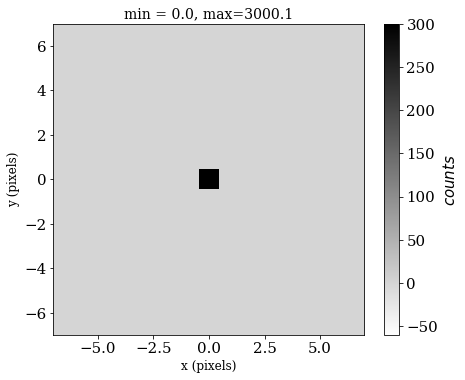

In [5]:
Atrue = 3000.12   # the true source flux (in photons / second)
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 

image = np.zeros((xdim, ydim))
image[7,7] = Atrue

plotCutout(image)

## Actually, photons are quantized...

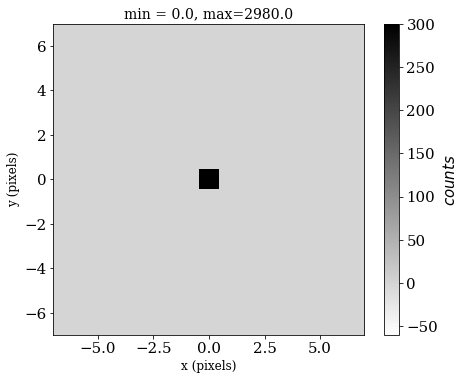

In [6]:
Atrue = 3000.12   # the true source flux (in photons/second)
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 

np.random.seed(42)
image = np.zeros((xdim, ydim))
image[7,7] = np.random.poisson(Atrue)

plotCutout(image)

## If we take many exposures

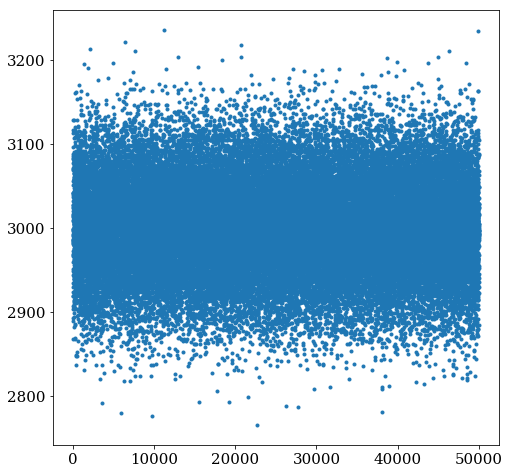

In [7]:
np.random.seed(43)
meas = np.random.poisson(Atrue, 50000)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(meas, '.')

## Or, as a histogram

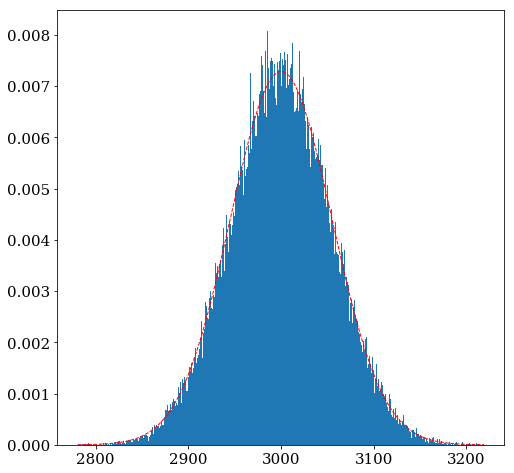

In [8]:
nsigma = int(np.floor(4*np.sqrt(Atrue)))
bins = np.linspace(Atrue - nsigma, Atrue + nsigma, 2*nsigma+1)-0.5
fig, ax = plt.subplots(figsize=(8,8))
n, bins, patches = ax.hist(meas, bins, density=True)

import scipy.stats
y = scipy.stats.norm.pdf(bins, Atrue, np.sqrt(Atrue))
ax.plot(bins, y, 'r--', linewidth=1)

So we can safely approximate Poisson noise with Gaussian noise for large N, and use the Gaussian as our model for the "measurement error". That brings us into the "least squares" regime of ML.

We'll soon make use of that observation.

## Atmosphere makes things more difficult

And the telescope, and the detector...

As the light travels through the atmosphere, it becomes scattered away from the single pixel it would ideally occupy. Instead of ending in a single ***point***, it ***spreads*** to a (hopefully small) spot on the detector.

![Snapshot from PhoSim simulation movie](figures/phosim-snapshot.jpg)

Credit: John Peterson and the PhoSim team, https://youtu.be/tfzT4JG2Trs .


## The Point Spread Function

How the light spread out is characterized by the **Point Spread Function** (the "PSF"). There are various contributions to the PSF, from minute misalignments in the optics, to the atmosphere, to diffusion of the electrons as they travel through the silicon in the CCD. But the dominant effect is the one ***from the atmosphere***.

![PSF Formation](figures/psf-formation.jpg)

## The Point Spread Function

In practice, we don't construct the PSF from *ab initio* considerations; instead, we measure it by looking at the observed shape of bright, isolated, point sources (i.e., stars). Those observations are noisy, so we fit analytical profiles to estimate the true PSF.

Which profiles to fit? A good description of the point spread function is the Moffat profile:

$$ I = I_0 \left[ 1 + \left( \frac{r}{\alpha} \right)^2 \right]^{-\beta} $$

where $r$ is the radius from the center of the object, $\alpha$ sets the overall size of the PSF spot, and $\beta$ controls the shape. This profile can be mathematically tedious to work with, so frequently a sum of Gaussians is used.

For simplicity, we will use just a single Gaussian here.

## The star imaged from the ground

Because of the aformentioned effects, our star will look like a PSF on the detector (the CCD).

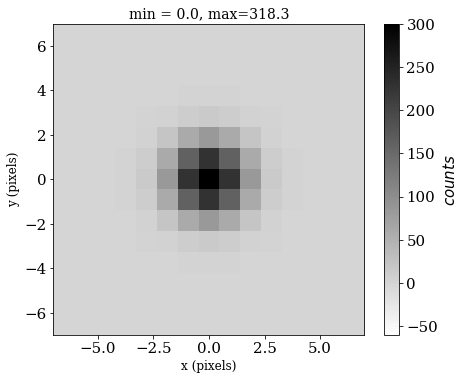

In [9]:
Atrue = 3000.12   # the true source flux
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)

plotCutout(image)

## The atmosphere also adds the background

Photons scatter in the atmosphere, both from the sky (e.g., moonlight) but also from the ground. This adds some (quite annoying) background to our image of the sky.

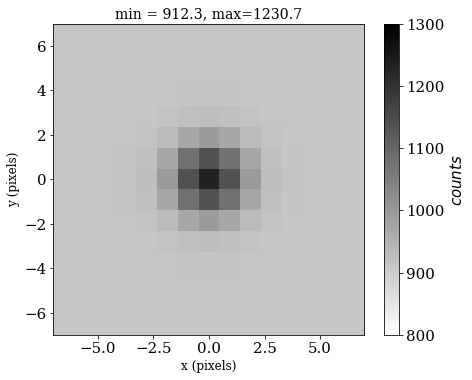

In [10]:
Atrue = 3000.12   # the true source flux
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid |
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 912.33    # sky background (photons / second)

image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
image += skyBg

plotCutout(image, clim=(800, 1300))
noiselessImage = image    # save it for later

## And let's not forget (again) that photons are quantized!

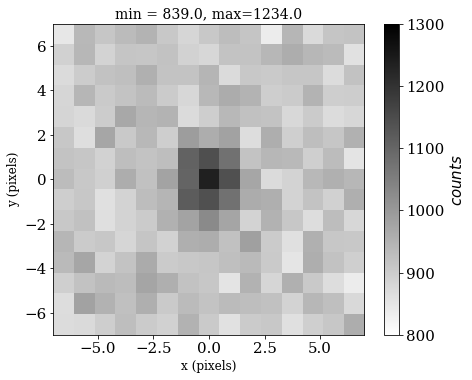

In [11]:
np.random.seed(43)

Atrue = 3000.12   # the true source flux
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 912.33    # sky background flux (photons / second)

image = np.zeros((xdim, ydim))
image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
image += skyBg
image = np.random.poisson(image)

plotCutout(image, clim=(800, 1300))
simulatedImage = image    # save it for later

## Congratulations!

We've just built a rudimentary simulator of astronomical images!

You can imagine how one could generalize it further (multiple objects, more complex objects, more complex PSFs, background that varies as a function of position, ...)

## Photometry (measuring the flux)

We now have an image that we observe, and some ***understanding of the processes that created it***.

Now we wish to estimate the flux. How should we do that?

## Aperture Photometry

Idea: pixels are "photon buckets"; let's count up how many photons they caught. We'll sum up the flux in some circular aperture around the source, and use that as an ***estimator*** of the total flux in the source. This is what's called ***aperture photometry***.

## But First: Estimate and remove the sky value

For our present purposes, I'll just assume I know it somehow.

(Discussion: how would you estimate it?)

## Image with the sky level removed

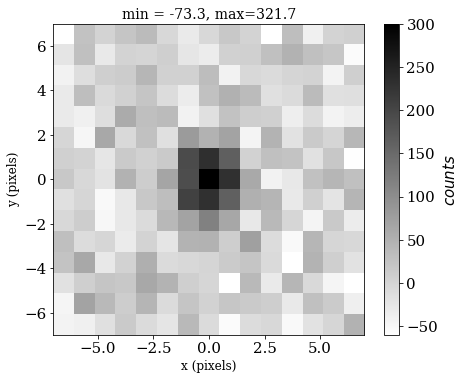

In [12]:
# First, subtract the sky background (assume we've estimated it (how?))
image = simulatedImage - skyBg

plotCutout(image)

## Aperture Photometry

A_ap(r=3) = 2577.4


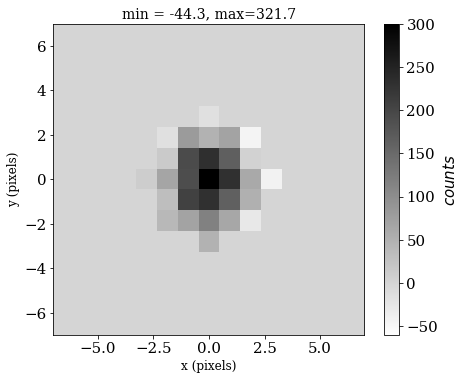

In [13]:
# Aperture photometry

def apPhot(image, r = 3, x0=0, y0=0):
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image[:]
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum(), apPhotImage

image = simulatedImage - skyBg

r = 3
count, apPhotImage = apPhot(image, r)

print('A_ap(r=%.0f) = %.1f' % (r, count))
plotCutout(apPhotImage)

## How well does aperture photometry do?

Let's turn off the noise for a second...

A_ap(r=3) = 2852.9


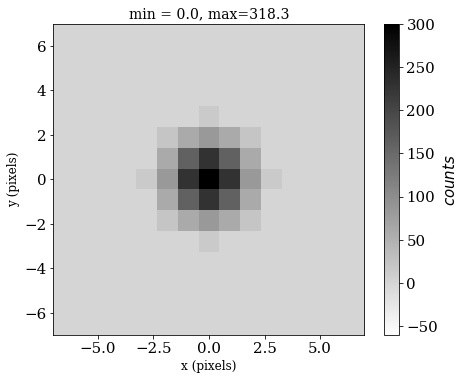

In [14]:
image = noiselessImage - skyBg

r = 3
count, apPhotImage = apPhot(image, r)

print('A_ap(r=%.0f) = %.1f' % (r, count))
plotCutout(apPhotImage)

## (Uncalibrated/Uncorrected) Aperture Photometry would introduce bias

This is a **biased and inconsistent estimator**. If we had an infinite number of observations, the mean would asymptote to a value lower than the true value because there's flux we miss in the outskirts of the object.

In real-life usage, we would calibrate this out by performing *aperture correction*, or consistently use the same aperture for both calibration stars and stars of interest (under the assumption that the PSF is constant!).

## PSF Photometry

Let us try to derive a better (more ***efficient***) estimator of the object flux.

## Maximum Likelihood estimation of the flux

Let's denote the total flux of the star as $A$. As we discussed above when we looked at how an astronomical image gets formed, our model is that the total flux $A$ gets spread out from the single central pixel into many (formally, infinitely many) surrounding pixels in the shape of the PSF.

So our **physical model** for the image is that it consists of the flux $A$ spread around in the shape of the PSF, plus the background $B$ (which we've removed):

$$ M(x,y) = B + A \cdot PSF(x - x_0, y - y_0) $$

and with the Poisson noise (caused by photon quantization), we obtain the full ***statistical model of each pixel*** as:

$$ I_{x,y} \sim Poisson(\lambda = M(x,y)). $$

As the Poisson distribution can be approximated by a Gaussian for large values ($\gtrsim 1000$) of $I(x, y)$, we can simplify that to:

$$ I_{x,y} \sim N\left(\mu = M(x,y), \sigma=\sqrt{M(x,y)}\right) $$

(note: the symbol $\sim$ is read as "has the probability distribution of", or "is drawn from"). 

## Maximum Likelihood estimation of the flux

This is practically identical to our case with fitting a line! The only difference is that instead of having one index $i$, we have two indices for the data points, $(x, y)$, and the errors are heteroscedastic (different value of $\sigma_{x,y}$ at each point $(x, y)$).

So we can readily write out the log-likelihood as:

$$ \ln L(A) = constant - \sum_{x,y} \frac{(I_{x,y} - M(x, y))^2}{2 \sigma_{x,y}^2} $$

where $I_{x,y}$ are the observed counts in pixel $(x,y)$ and $M(x,y)$ are the values model would predict.

Note #1: Note how ***each pixel*** acts as an independent data point that constrains our model.

Note #2: The best way to think of this expression is as:

$$ \ln L(A) = constant - \sum_{data} \frac{(data - model)^2}{2 \cdot variance} $$.

where $data$, $model$, and $variance$ are implicitly summed over whichever indices exist in the problem (e.g., $x,y$ coordinates in images, or the $i$ index in fitting a line).

Note #3: As the randomness of count in each pixel comes from quantization of photons -- Poisson noise -- and is in the limit where it's approximately Gaussian -- making $variance = model$ (see previous slide) and therefore:

$$ \ln L(A) = constant - \frac{1}{2} \sum_{data} \frac{(data - model)^2}{model} = constant - \frac{1}{2} \chi^2 $$.

Maximizing the likelihood of a product of normal distribution reduces to minimizing the $\chi^2$, which is what we'll do next.

## Let's see what happens for the true value of $A$

chi^2/dof = 1.02, stdev = 0.094


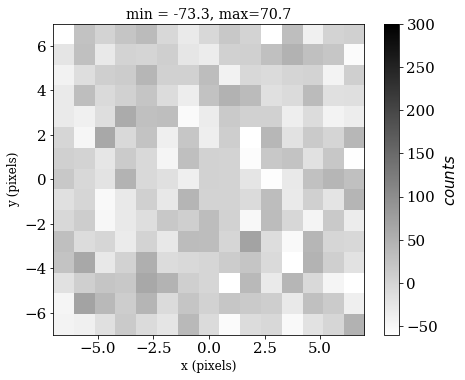

In [15]:
image = simulatedImage

# Generate the model
model = np.zeros((xdim, ydim))
model = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
model += skyBg

chi2 = np.sum((image - model)**2 / model)
print("chi^2/dof = %.2f, stdev = %.3f" % (chi2 / (image.size - 1), np.sqrt(2. / (image.size - 1))))

plotCutout(image-model)

which *looks* reasonable. Let's examine it some more.

## Perfect measurement (no photon or other noise)

chi^2/dof = 0.00, stdev = 0.094


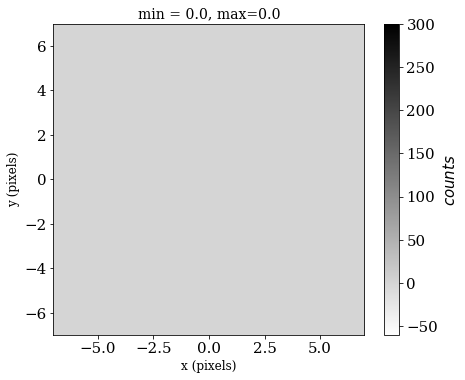

In [16]:
image = noiselessImage

# Subtract the correct model
model = np.zeros((xdim, ydim))
model = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
model += skyBg

chi2 = np.sum((image - model)**2 / model)
print("chi^2/dof = %.2f, stdev = %.3f" % (chi2 / (image.size - 1), np.sqrt(2. / (image.size - 1))))

plotCutout(image-model)

This is not surprising: we've generated the original image by multiplying the true flux with the PSF. Here, we're subtracting exactly the same thing, and the result must be identically zero.

## Estimating the true flux

We estimate the flux by minimizing the $\chi^2$.

Let's try it first without the noise first:

A_ML = 3000.1 with chi^2/dof = 0.00


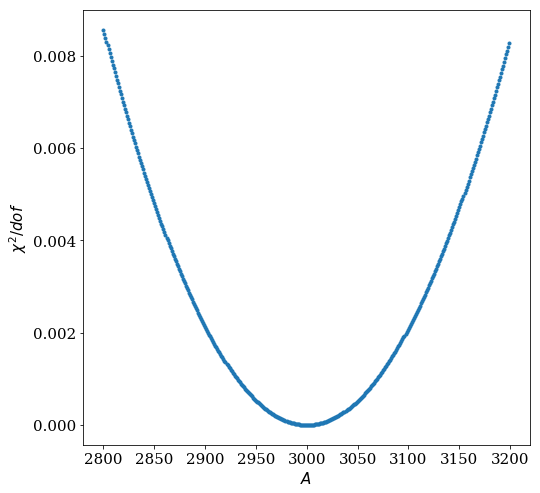

In [17]:
def psfPhot(image, Amin, Amax):
    """ Perform PSF photometry with a PSF=N(x=0,y=0,\sigma=sigmaPSF)"""
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf + skyBg
        chi2 = np.sum((image - model)**2 / model)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best, testA, chi2dof

image = noiselessImage.astype('f8')

((bestA, bestChi2dof), testA, chi2dof) = psfPhot(image, Atrue - 200, Atrue + 200)
print("A_ML = %.1f with chi^2/dof = %.2f" % (bestA, bestChi2dof))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, chi2dof, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$\chi^2/dof$");

Excellent!

## Now with measurement noise

A_ML = 2973.1 with chi^2/dof = 1.02


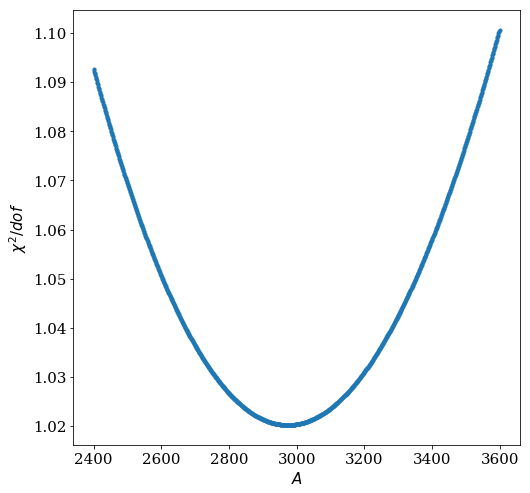

In [18]:
image = np.copy(simulatedImage)

((bestA, bestChi2dof), testA, chi2dof) = psfPhot(image, Atrue - 600, Atrue + 600)
print("A_ML = %.1f with chi^2/dof = %.2f" % (bestA, bestChi2dof))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, chi2dof, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$\chi^2/dof$");

## Or we can also plot the likelihood instead

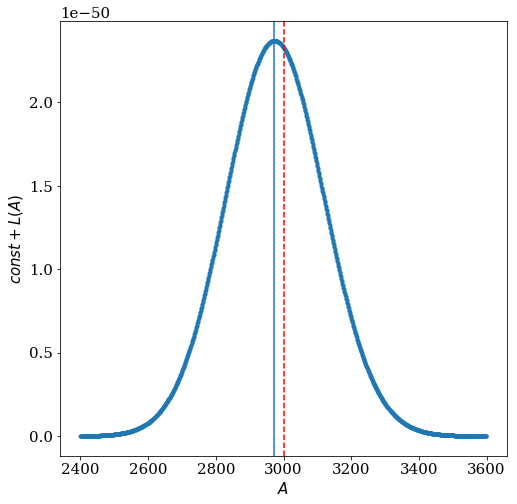

In [19]:
lnL = np.exp(-0.5*(chi2dof*(image.size-1)))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(testA, lnL, '.')
ax.set_xlabel(r"$A$")
ax.set_ylabel(r"$const + L(A)$")

ax.axvline(x=bestA)
ax.axvline(x=Atrue, color='red', linestyle='--')

## Models with more parameters

In the example above, we've numerically solved (brute forced!) a problem for which an analytic solution exists (e.g., we could've just solved $\partial \ln L / \partial A = 0$ for $A$; see http://ls.st/lse-40 for the solution).

It has the benefit of being general, however. We can apply the same technique to models with more parameters (within the limits of the computing power available to us!). The other parameters could be the position of the object ($x$, $y$), or some measure of the shape of the object.

As the number of parameters increases, the likelihood curve from the previous slide becomes the ***likelihood (hyper)surface***. The more dimensions there are, the more difficult (computationally expensive) it becomes to find its maximum using brute force solutions; even for 2D cases, we're likely to resort to ***minimization algorithms*** (e.g., Levenberg–Marquardt or others).

## Example: Measuring the size and brightness of a spherical, gaussian, galaxy

Let's explore a two-dimensional case.

Imagine that, instead of a star, we're observing a galaxy. Even in the ideal (space) case, the Galaxy will not be a point source. We'll imagine we're dealing with a "Gaussian spherical galaxy" -- i.e., one whose intensity of light falls of as a 2D gaussian would. As with the star, we'll asume the position of the galaxy is known.

Our model has two parameters: the measure of the extendedness of the galaxy -- $\sigma$ -- and its total flux, $C$:

$$ M(x, y) = \frac{C}{2 \pi \sigma^2} \exp \left( -\frac{(x-x_0)^2 + (y-y_0)^2}{2\sigma^2} \right) $$

Our code will now have to explore the likelihood surface in $(C, \sigma)$ space, and find the point of its maximum.

Note #1: $C$ here is the same as $A$ previously -- the total flux of the object. We use $C$ for the galaxy to be closer to the nomenclature of http://ls.st/lse-40.

Note #2: When generating the simulated image, $I(x, y)$ needs to be ***convolved*** with the PSF. Fortunately (actually, on purpose!) we've chosen the galaxy profile to be gaussian, and the convolution of two gaussians with variances $\sigma_1^2$ and $\sigma_2^2$ is also a gaussian with the variance $\sigma_1^2 + \sigma_2^2$ (i.e., it's wider). Our function `gauss2D` utilizes this fact to generate the convolved image of the galaxy.

## Helper functions

Plotting functions

In [20]:
def FourPanelPlot(nonoise, psf, image, diffimage):
    """
        Make a 4-panel plot of the noiseless image, the psf, the image with noise, and the difference.
    """
    ## nonoise -- noiseless image, N x N array
    ## psf -- the image of the PSF, N x N array
    ## image -- image with the added noise, N x N array
    ## diffimage -- difference image (image - psf)

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0.13, bottom=0.15, right=0.95, top=0.90, wspace=0.18, hspace=0.46)

    images = [
        (221, nonoise, "noiseless image",   ['',          r' ',          r'y (pixels)'], (800, 1200)),
        (223, psf,     "model image",       ['',          r'x (pixels)', r'y (pixels)'], (800, 1200)),
        (222, image,   "image with noise",  [r'$counts$', r' ',          r''], (800, 1200)),
        (224, diffimage, "image - model",   [r'$counts$', r'x (pixels)', r''], (-60, 60))
    ]

    for (loc, img, title, (clabel, xlabel, ylabel), clim) in images:
        plotCutout(img, title, clabel, xlabel, ylabel, loc, fig, clim)

def plotLikelihood(chiPixSig, chiPixCmod, lnL, Ctrue, sigtrue, sigmaML, CmodML):

    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.90, wspace=0.29, hspace=0.46)

    ## renormalize and truncate for clean plotting
    lnL -= lnL.max()
    lnL[lnL < -6] = -6
    lnL[np.isnan(lnL)] = -6

    ## lnL image 
    ax = fig.add_axes([0.35, 0.35, 0.45, 0.6], xticks=[], yticks=[])
    ax.set_title('ln(L) image', fontsize=14)
    # pretty color map
    plt.imshow(lnL, origin='lower', extent=(chiPixSig[0], chiPixSig[-1], chiPixCmod[0], \
                                            chiPixCmod[-1]), cmap=plt.cm.RdYlGn, aspect='auto')

    # mark true values     
    ax.plot(sigtrue, Ctrue, 'o', color='red', alpha=0.75)
    # mark ML solution: (sigmaML, CmodML)
    ax.plot(sigmaML, CmodML, 'x', color='white', alpha=0.99, lw=35)

    # colorbar
    cax = plt.axes([0.82, 0.35, 0.02, 0.6])
    cb = plt.colorbar(cax=cax)
    cb.set_label(r'$lnL(\sigma, C_{mod})$', fontsize=14)
    plt.clim(np.min(lnL), np.max(lnL))

    # contours
    # plt.contour(chiPixSig, chiPixCmod, convert_to_stdev(lnL), levels=(0.683, 0.955, 0.997), colors='w')

    # marginal projections
    p_sigma = np.exp(lnL).sum(0)
    p_Cmod = np.exp(lnL).sum(1)
  
    ax1 = fig.add_axes([0.35, 0.1, 0.45, 0.23], yticks=[])
    ax1.plot(chiPixSig, p_sigma, '-k')
    ax1.set_xlabel(r'$\sigma$ (pixel)', fontsize=12)
    ax1.set_ylabel(r'$p(\sigma)$', fontsize=12)
    ax1.set_xlim(np.min(chiPixSig), np.max(chiPixSig))

    ax2 = fig.add_axes([0.15, 0.35, 0.18, 0.6], xticks=[])
    ax2.plot(p_Cmod, chiPixCmod, '-k')
    ax2.set_ylabel(r'$C_{mod}$ (counts)', fontsize=12)
    ax2.set_xlabel(r'$p(C_{mod})$', fontsize=12)
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse x axis
    ax2.set_ylim(np.min(chiPixCmod), np.max(chiPixCmod))

Functions that simulate the image, and compute the likelihood surfaces

In [21]:
### computations 
def gauss2D(muX, muY, sig, A, skyBg, sigPSF, Xpixels, Ypixels):
    """
    Generate an image of size (Xpixels, Ypixels) with
    a 2D circular Gaussian of total flux A
    with standard deviation sigma^2=sig^2 + sigPSF^2
    superimposed on a uniform background B and centered
    on (muX, muY).
    """
    r = np.sqrt((Xpixels-muX)**2 + (Ypixels-muY)**2)
    # make and set image to the background value
    image = np.full(r.shape, skyBg)

    ## now add circular gaussian profile (normalized to A)
    # source gauss convolved with single-gauss PSF  
    sigConvSquare = sig**2 + sigPSF**2
    image += A*np.exp(-r**2/2/sigConvSquare) / (2*math.pi*sigConvSquare)
    return image


### make chi2(sigma, Cmod) image, find the ML solution, and return the best-fit model image 
def getlnLimage(xpix, image, muX, muY, skyBg, sigmaPSF): 
    """
    Comput the log-likelihood image.
    """

    # a little helper 
    def lnLinit(yPixels, xPixels):
        lnL = np.zeros(xPixels.shape, dtype=float) - 0 * np.log(yPixels)
        return lnL

    ## first make the log likelihood (lnL) image
    # define the grid
    chiPixelsSigma = np.linspace(0, 2, 201)
    chiPixelsCmod = np.linspace(2000, 4000, 401)
    lnL = lnLinit(chiPixelsCmod[:, None], chiPixelsSigma)

    # brute force loop over all sigma and Cmod
    chi2min = np.inf
    sigmaML = -1.0
    CmodML = -1.0
    for i in range(0, chiPixelsSigma.size):
        sigma = chiPixelsSigma[i]
        for j in range(0,chiPixelsCmod.size):
            Cmod = chiPixelsCmod[j]
            # model image: a circular 2D gaussian 
            model = gauss2D(muX, muY, sigma, Cmod, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
            thisChi2 = np.sum((image - model)**2 / model)
            lnL[j][i] = thisChi2   # NB this is chi2, not yet lnL (see below)
            if (thisChi2 < chi2min): 
                chi2min = thisChi2
                sigmaML = sigma
                CmodML = Cmod
                
    ## go from chi2 to ln(L) 
    # since L = exp(-chi2/2): lnL = -1/2 * chi2
    lnL = -0.5*lnL
            
    # ML model
    bestModel = gauss2D(muX, muY, sigmaML, CmodML, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
    # chi2 per degree of freedom
    chi2minDOF = chi2min / (xpix.size**2 - 2)
    return chiPixelsSigma, chiPixelsCmod, lnL, bestModel, sigmaML, CmodML, chi2minDOF

Driver functions

In [22]:
def simulate(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF, seed=15):
    # set seed
    np.random.seed(seed)
    
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    ## make psf (sigtrue=0) 
    psf = gauss2D(muXtrue, muYtrue, 0, Ctrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)

    ## make noiseless image (convolved with psf given by sigmaPSF, image size given by 1Dpixels) 
    nonoise = gauss2D(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
 
    ## now add noise
    image = np.random.poisson(nonoise)

    ## difference object - psf
    diffimage = image - psf

    return nonoise, psf, image, diffimage

def printMLResults(sigmaML, CmodML, chi2minDOF, bestModel, image, psf):
    print('The Maximum Likelihood point:')
    print('  sigmaML = ', sigmaML)
    print('   CmodML = ', CmodML)
    print('  chi2DOF = ', chi2minDOF)

def demo(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF, seed=42):
    # define the (square) grid
    xpix = np.linspace(-7, 7, 15)

    nonoise, psf, image, diffimage = simulate(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF, seed)
    chiPixSig, chiPixCmod, lnLimage, bestModel, sigmaML, CmodML, chi2minDOF = getlnLimage(xpix, image, muXtrue, muYtrue, skyBg, sigmaPSF)

    # compute model and residuals
    xpix = np.linspace(-7, 7, 15)
    model = gauss2D(muXtrue, muYtrue, sigmaML, CmodML, skyBg, sigmaPSF, xpix[:, np.newaxis], xpix)
    diffimage = image - model

    # visualize results
    FourPanelPlot(nonoise, model, image, diffimage)
    printMLResults(sigmaML, CmodML, chi2minDOF, bestModel, image, psf)
    plotLikelihood(chiPixSig, chiPixCmod, lnLimage, Ctrue, sigtrue, sigmaML, CmodML)

    return xpix, nonoise, psf, image, diffimage


## Sanity check: a star

In [23]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

The Maximum Likelihood point:
  sigmaML =  0.0
   CmodML =  2965.0
  chi2DOF =  1.1708740116930998


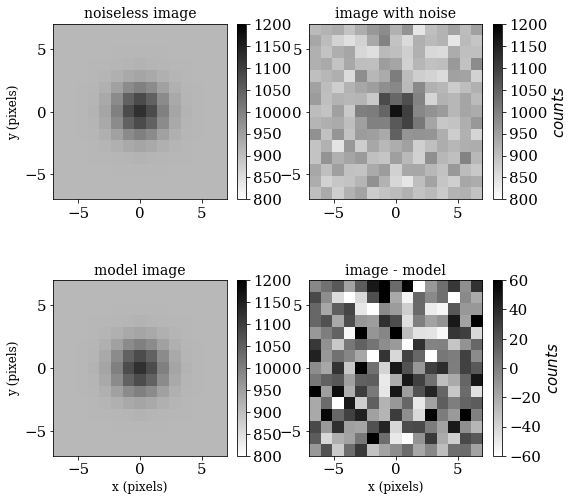

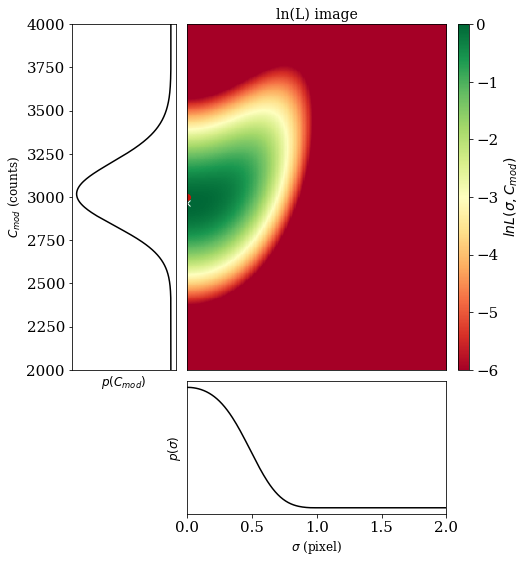

In [24]:
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid 
sigtrue = 0.0     # the intrinsic gaussian source width, sigma (in pixels) 
Ctrue = 3000.12   # the source count normalization
skyBg = 912.33    # sky background

demo(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF);

The Maximum Likelihood point:
  sigmaML =  0.91
   CmodML =  2870.0
  chi2DOF =  1.1560856192957263


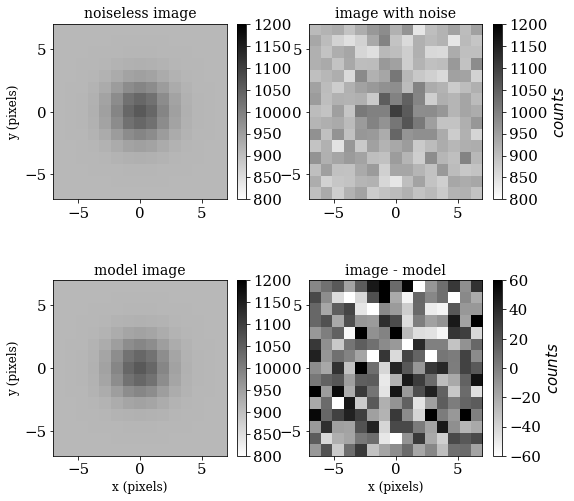

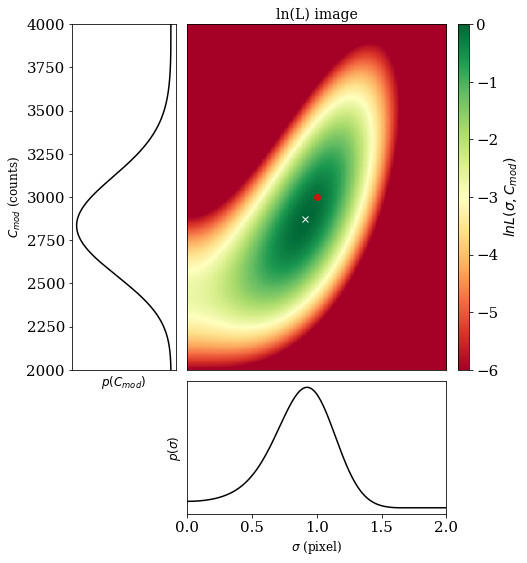

In [25]:
sigtrue = 1.0     # the intrinsic gaussian source width, sigma (in pixels) 
demo(muXtrue, muYtrue, sigtrue, Ctrue, skyBg, sigmaPSF);

## Forward modeling

What we've seen here is an example of ***forward modeling***, where we estimate the parameters of the model by generating realizations of the model, comparing them to measured data, and selecting (in this case, by Maximum Likelihood) the value of parameters for which the simulation is "closest" to the model:

It illustrates the ***strong link between the ability to *simulate* the process of interest, and *optimally estimating* its parameters*** -- if you're able to do the former, you can do the latter (modulo computational cost). That is why simulations (not just n-body, but, say, a simulation of how a spectrum image is formed in the spectrograph) are tremendously important in science today.

## Summary

ML estimators are the standard workhorse for estimation of parameter values all across astronomy. Today we've seen how they can be used to perform stellar PSF photometry and shape measurement of objects. We've also learned a bit about image processing in astronomy.

Though the details may be more complicated, ***what you've seen today is very similar in spirit to what even the most sophisticated image processing codes do today***.

For more on this topic, read "Photon Rates and SNR Calculations" by Ivezic, Jones & Lupton (http://ls.st/lse-40; especially Section 4).

Next week we'll turn to similar problems in the Bayesian framework!